In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb

project_name = "master-thesis"

interesting_run_names = ["baseline-phcd-paper", "architecture-1-phcd_paper", "architecture-2-phcd_paper", "architecture-7-phcd_paper" ] # "architecture-3-phcd_paper", "architecture-7-phcd_paper"
architectures = ["Bazowa", "Architektura A", "Architektura B", "Architektura C" ]
plot_titles = ["Dokładność architektury bazowej", "Dokładność architektury A", "Dokładność architektury B", "Dokładność architektury C" ]
api = wandb.Api()

# get all runs for a project    
runs = api.runs(f"gratkadlafana/{project_name}")

run_ids = []
for name in interesting_run_names:
    # get run id
    run_id = [run.id for run in runs if run.name == name and run.state == "finished"][0]
    print(f"Run {name}, id: {run_id}")
    run_ids.append(run_id)

In [ ]:
results_table = pd.DataFrame(columns=["run_name", "test acc", "number of parameters", "GFLOPs", "throughput [images / s]", "compressed disk size [bytes]"])
for run_id, run_name in zip(run_ids, interesting_run_names):
    # for each run get the metrics and save them to the results_table
    run = api.run(f"gratkadlafana/{project_name}/{run_id}")
    metrics = run.summary
    new_row = pd.DataFrame({
        "run_name": run_name,
        "test acc": metrics["test_accuracy"],
        "number of parameters": metrics["num_parameters"],
        "GFLOPs": metrics["model_flops"],
        "throughput [images / s]": metrics["throughput"],
        "compressed disk size [bytes]": metrics["compressed_disk_size"]
    },
    index=[0])
    results_table = pd.concat([results_table, new_row], ignore_index=True)

results_table["compressed disk size [Mb]"] = results_table["compressed disk size [bytes]"].map(lambda x : round(x / 1024 / 1024, 3)) 
results_table["FLOPs (milions)"] = results_table["GFLOPs"].map(lambda x: round(x * 1000, 3))
results_table["number of parameters (thousands)"] = results_table["number of parameters"].map(lambda x : round(x / 1000, 3))
results_table["throughput [thousands of images / s]"] = results_table["throughput [images / s]"].map(lambda x : round(x / 1000, 3))
results_table["label"] = results_table["run_name"].map(lambda x : architectures[interesting_run_names.index(x)])

results_table = results_table[["run_name", "label", "test acc", "number of parameters (thousands)", "FLOPs (milions)", "compressed disk size [Mb]", "throughput [thousands of images / s]"]]
display(results_table)

# Measure

In [ ]:
import pathlib
import shutil
import os
import time
import datetime
import numpy as np
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import zipfile

from typing import List

def load_data(run, artifact_name = "phcd_paper_splits_tfds") -> List[tf.data.Dataset]:
    """
    Downloads datasets from a wandb artifact and loads them into a list of tf.data.Datasets.
    """

    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = pathlib.Path(
        f"./artifacts/{artifact.name.replace(':', '-')}"
    ).resolve()
    if not artifact_dir.exists():
        artifact_dir = artifact.download()
        artifact_dir = pathlib.Path(artifact_dir).resolve()

    # if tf.__version__ minor is less than 10, use
    # tf.data.experimental.load instead of tf.data.Dataset.load

    if int(tf.__version__.split(".")[1]) < 10:
        load_function = tf.data.experimental.load
    else:
        load_function = tf.data.Dataset.load
    
    output_list = []
    for split in ["train", "test", "val"]:
        ds = load_function(str(artifact_dir / split), compression="GZIP")
        output_list.append(ds)
    
    return output_list


def plot_accuracy_per_class(class_accuracy_dict):
    plt.figure(figsize=(10, 5))
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    plt.bar(labels, class_accuracy)
    plt.xticks(labels)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per class")
    plt.show()

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    labels_iterator= ds.map(lambda x, y: y).as_numpy_iterator()
    labels = np.concatenate(list(labels_iterator))
    return len(np.unique(labels))

def get_number_of_examples(ds: tf.data.Dataset) -> int:
    """
    Returns the number of examples in a dataset.
    """
    return sum(1 for _ in ds)

def preprocess_dataset(ds: tf.data.Dataset, batch_size: int, cache: bool = True) -> tf.data.Dataset:
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
    ds = ds.unbatch().batch(batch_size)
    if cache:
        ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [29]:
artifact_base_name = "phcd_paper"
artifact_name = f"{artifact_base_name}_splits_tfds" # "phcd_paper_splits_tfds
run = wandb.init(project="master-thesis", job_type="measure")
    
bs = 64
_, ds_test, _ = load_data(run, artifact_name=artifact_name)

num_classes = get_number_of_classes(ds_test)
ds_test = preprocess_dataset(ds_test, batch_size=bs, cache=False)

In [30]:
import tqdm

def calculate_model_throughput(model, test_dataset, batch_size, n=10) -> float:
    '''
    Calculates the average throughput of a model over 50 batch predictions of 100 batches, in images per second.
    '''
    output = []

    for _ in tqdm.tqdm(range(n)):
        start = time.time()
        model.predict(test_dataset.take(1000))
        end = time.time()
        output.append((100 * batch_size) / (end - start))
    return output

In [31]:
throughputs_results = []
# for each run_name, download model_baseline.h5
for run_id, run_name in zip(run_ids, interesting_run_names):
    print(f"Downloading model for run {run_name}...")
    run = api.run(f"gratkadlafana/{project_name}/{run_id}")
    file = run.file("model_baseline.h5")
    file.download(replace=True, root="models")

    # load model
    model = tf.keras.models.load_model("models/model_baseline.h5"
    print(f"Calculating throughput for run {run_name}...")
    # calculate throughput
    t1 = time.time()
    throughput = calculate_model_throughput(model, ds_test, bs, n=150)
    t2 = time.time()
    print(f"Throughput calculation took {t2 - t1} seconds.")
    for t in throughput:
        throughputs_results.append({"run_name": run_name, "throughput [images / s]": t})

throughput_df = pd.DataFrame(throughputs_results)
display(throughput_df)

Calculating throughput for run baseline-phcd-paper...


  0%|          | 0/150 [00:00<?, ?it/s]

872/872 [==============================] - 13s 15ms/step


  1%|          | 1/150 [00:13<34:02, 13.71s/it]

872/872 [==============================] - 14s 16ms/step


  1%|▏         | 2/150 [00:28<35:09, 14.26s/it]

872/872 [==============================] - 17s 19ms/step


  2%|▏         | 3/150 [00:45<38:17, 15.63s/it]

872/872 [==============================] - 21s 24ms/step


  3%|▎         | 4/150 [01:07<43:49, 18.01s/it]

872/872 [==============================] - 21s 24ms/step


  3%|▎         | 5/150 [01:28<46:04, 19.06s/it]

872/872 [==============================] - 22s 26ms/step


  4%|▍         | 6/150 [01:50<48:47, 20.33s/it]

872/872 [==============================] - 22s 25ms/step


  5%|▍         | 7/150 [02:13<50:00, 20.99s/it]

872/872 [==============================] - 22s 25ms/step


  5%|▌         | 8/150 [02:35<50:28, 21.33s/it]

872/872 [==============================] - 20s 23ms/step


  6%|▌         | 9/150 [02:55<49:07, 20.91s/it]

872/872 [==============================] - 19s 22ms/step


  7%|▋         | 10/150 [03:14<47:38, 20.42s/it]

872/872 [==============================] - 19s 22ms/step


  7%|▋         | 11/150 [03:34<46:43, 20.17s/it]

872/872 [==============================] - 19s 22ms/step


  8%|▊         | 12/150 [03:53<46:02, 20.02s/it]

872/872 [==============================] - 19s 21ms/step


  9%|▊         | 13/150 [04:12<44:53, 19.66s/it]

872/872 [==============================] - 21s 25ms/step


  9%|▉         | 14/150 [04:34<46:03, 20.32s/it]

872/872 [==============================] - 23s 26ms/step


 10%|█         | 15/150 [04:57<47:26, 21.08s/it]

872/872 [==============================] - 20s 23ms/step


 11%|█         | 16/150 [05:18<46:47, 20.95s/it]

872/872 [==============================] - 20s 23ms/step


 11%|█▏        | 17/150 [05:38<46:07, 20.81s/it]

872/872 [==============================] - 19s 22ms/step


 12%|█▏        | 18/150 [05:58<44:51, 20.39s/it]

872/872 [==============================] - 19s 22ms/step


 13%|█▎        | 19/150 [06:17<43:43, 20.02s/it]

872/872 [==============================] - 19s 21ms/step


 13%|█▎        | 20/150 [06:36<42:43, 19.72s/it]

872/872 [==============================] - 19s 21ms/step


 14%|█▍        | 21/150 [06:55<41:55, 19.50s/it]

872/872 [==============================] - 19s 21ms/step


 15%|█▍        | 22/150 [07:14<41:10, 19.30s/it]

872/872 [==============================] - 19s 21ms/step


 15%|█▌        | 23/150 [07:32<40:34, 19.17s/it]

872/872 [==============================] - 20s 23ms/step


 16%|█▌        | 24/150 [07:53<40:58, 19.51s/it]

872/872 [==============================] - 20s 23ms/step


 17%|█▋        | 25/150 [08:13<41:19, 19.84s/it]

872/872 [==============================] - 20s 23ms/step


 17%|█▋        | 26/150 [08:34<41:26, 20.05s/it]

872/872 [==============================] - 20s 23ms/step


 18%|█▊        | 27/150 [08:54<41:12, 20.10s/it]

872/872 [==============================] - 19s 22ms/step


 19%|█▊        | 28/150 [09:14<40:36, 19.97s/it]

872/872 [==============================] - 19s 22ms/step


 19%|█▉        | 29/150 [09:33<39:49, 19.75s/it]

872/872 [==============================] - 19s 21ms/step


 20%|██        | 30/150 [09:52<38:58, 19.48s/it]

872/872 [==============================] - 18s 21ms/step


 21%|██        | 31/150 [10:10<38:03, 19.19s/it]

872/872 [==============================] - 18s 21ms/step


 21%|██▏       | 32/150 [10:29<37:20, 18.99s/it]

872/872 [==============================] - 18s 21ms/step


 22%|██▏       | 33/150 [10:47<36:44, 18.84s/it]

872/872 [==============================] - 18s 21ms/step


 23%|██▎       | 34/150 [11:06<36:18, 18.78s/it]

872/872 [==============================] - 19s 22ms/step


 23%|██▎       | 35/150 [11:26<36:24, 19.00s/it]

872/872 [==============================] - 19s 22ms/step


 24%|██▍       | 36/150 [11:45<36:31, 19.23s/it]

872/872 [==============================] - 19s 22ms/step


 25%|██▍       | 37/150 [12:05<36:28, 19.37s/it]

872/872 [==============================] - 19s 22ms/step


 25%|██▌       | 38/150 [12:25<36:17, 19.44s/it]

872/872 [==============================] - 19s 21ms/step


 26%|██▌       | 39/150 [12:44<35:45, 19.33s/it]

872/872 [==============================] - 18s 21ms/step


 27%|██▋       | 40/150 [13:02<34:52, 19.02s/it]

872/872 [==============================] - 18s 20ms/step


 27%|██▋       | 41/150 [13:20<33:58, 18.70s/it]

872/872 [==============================] - 18s 20ms/step


 28%|██▊       | 42/150 [13:38<33:15, 18.47s/it]

872/872 [==============================] - 18s 20ms/step


 29%|██▊       | 43/150 [13:56<32:42, 18.34s/it]

872/872 [==============================] - 18s 21ms/step


 29%|██▉       | 44/150 [14:14<32:23, 18.33s/it]

872/872 [==============================] - 18s 20ms/step


 30%|███       | 45/150 [14:32<31:56, 18.25s/it]

872/872 [==============================] - 19s 21ms/step


 31%|███       | 46/150 [14:51<32:01, 18.48s/it]

872/872 [==============================] - 19s 21ms/step


 31%|███▏      | 47/150 [15:10<31:57, 18.61s/it]

872/872 [==============================] - 19s 22ms/step


 32%|███▏      | 48/150 [15:30<32:01, 18.83s/it]

872/872 [==============================] - 19s 22ms/step


 33%|███▎      | 49/150 [15:49<31:56, 18.97s/it]

872/872 [==============================] - 19s 22ms/step


 33%|███▎      | 50/150 [16:08<31:45, 19.05s/it]

872/872 [==============================] - 18s 20ms/step


 34%|███▍      | 51/150 [16:26<31:00, 18.79s/it]

872/872 [==============================] - 18s 20ms/step


 35%|███▍      | 52/150 [16:44<30:21, 18.59s/it]

872/872 [==============================] - 18s 20ms/step


 35%|███▌      | 53/150 [17:03<29:51, 18.47s/it]

872/872 [==============================] - 18s 21ms/step


 36%|███▌      | 54/150 [17:21<29:26, 18.40s/it]

872/872 [==============================] - 18s 21ms/step


 37%|███▋      | 55/150 [17:39<29:07, 18.39s/it]

872/872 [==============================] - 18s 21ms/step


 37%|███▋      | 56/150 [17:58<28:51, 18.42s/it]

872/872 [==============================] - 19s 21ms/step


 38%|███▊      | 57/150 [18:17<28:47, 18.57s/it]

872/872 [==============================] - 19s 22ms/step


 39%|███▊      | 58/150 [18:36<28:54, 18.85s/it]

872/872 [==============================] - 19s 22ms/step


 39%|███▉      | 59/150 [18:55<28:47, 18.98s/it]

872/872 [==============================] - 19s 22ms/step


 40%|████      | 60/150 [19:15<28:50, 19.22s/it]

872/872 [==============================] - 19s 22ms/step


 41%|████      | 61/150 [19:34<28:33, 19.25s/it]

872/872 [==============================] - 18s 20ms/step


 41%|████▏     | 62/150 [19:53<27:45, 18.93s/it]

872/872 [==============================] - 18s 21ms/step


 42%|████▏     | 63/150 [20:11<27:09, 18.74s/it]

872/872 [==============================] - 18s 21ms/step


 43%|████▎     | 64/150 [20:29<26:45, 18.66s/it]

872/872 [==============================] - 18s 21ms/step


 43%|████▎     | 65/150 [20:48<26:27, 18.68s/it]

872/872 [==============================] - 18s 21ms/step


 44%|████▍     | 66/150 [21:06<26:00, 18.58s/it]

872/872 [==============================] - 18s 21ms/step


 45%|████▍     | 67/150 [21:25<25:36, 18.51s/it]

872/872 [==============================] - 19s 21ms/step


 45%|████▌     | 68/150 [21:44<25:30, 18.66s/it]

872/872 [==============================] - 19s 22ms/step


 46%|████▌     | 69/150 [22:03<25:33, 18.94s/it]

872/872 [==============================] - 20s 22ms/step


 47%|████▋     | 70/150 [22:23<25:38, 19.23s/it]

872/872 [==============================] - 19s 21ms/step


 47%|████▋     | 71/150 [22:42<25:12, 19.14s/it]

872/872 [==============================] - 18s 21ms/step


 48%|████▊     | 72/150 [23:01<24:42, 19.01s/it]

872/872 [==============================] - 18s 20ms/step


 49%|████▊     | 73/150 [23:19<23:57, 18.67s/it]

872/872 [==============================] - 17s 19ms/step


 49%|████▉     | 74/150 [23:36<23:04, 18.22s/it]

872/872 [==============================] - 18s 20ms/step


 50%|█████     | 75/150 [23:54<22:36, 18.09s/it]

872/872 [==============================] - 18s 20ms/step


 51%|█████     | 76/150 [24:12<22:16, 18.06s/it]

872/872 [==============================] - 18s 21ms/step


 51%|█████▏    | 77/150 [24:30<22:03, 18.13s/it]

872/872 [==============================] - 18s 21ms/step


 52%|█████▏    | 78/150 [24:48<21:50, 18.20s/it]

872/872 [==============================] - 19s 21ms/step


 53%|█████▎    | 79/150 [25:07<21:46, 18.40s/it]

872/872 [==============================] - 19s 22ms/step


 53%|█████▎    | 80/150 [25:27<21:51, 18.73s/it]

872/872 [==============================] - 19s 21ms/step


 54%|█████▍    | 81/150 [25:46<21:40, 18.85s/it]

872/872 [==============================] - 19s 22ms/step


 55%|█████▍    | 82/150 [26:05<21:34, 19.04s/it]

872/872 [==============================] - 19s 22ms/step


 55%|█████▌    | 83/150 [26:25<21:25, 19.19s/it]

872/872 [==============================] - 18s 21ms/step


 56%|█████▌    | 84/150 [26:44<20:54, 19.01s/it]

872/872 [==============================] - 18s 21ms/step


 57%|█████▋    | 85/150 [27:02<20:25, 18.85s/it]

872/872 [==============================] - 18s 20ms/step


 57%|█████▋    | 86/150 [27:20<19:54, 18.66s/it]

872/872 [==============================] - 18s 20ms/step


 58%|█████▊    | 87/150 [27:38<19:23, 18.47s/it]

872/872 [==============================] - 18s 21ms/step


 59%|█████▊    | 88/150 [27:57<19:07, 18.50s/it]

872/872 [==============================] - 18s 20ms/step


 59%|█████▉    | 89/150 [28:15<18:39, 18.36s/it]

872/872 [==============================] - 18s 21ms/step


 60%|██████    | 90/150 [28:34<18:28, 18.47s/it]

872/872 [==============================] - 18s 21ms/step


 61%|██████    | 91/150 [28:52<18:11, 18.49s/it]

872/872 [==============================] - 18s 20ms/step


 61%|██████▏   | 92/150 [29:10<17:43, 18.33s/it]

872/872 [==============================] - 18s 21ms/step


 62%|██████▏   | 93/150 [29:28<17:24, 18.33s/it]

872/872 [==============================] - 19s 22ms/step


 63%|██████▎   | 94/150 [29:48<17:27, 18.71s/it]

872/872 [==============================] - 19s 21ms/step


 63%|██████▎   | 95/150 [30:07<17:15, 18.82s/it]

872/872 [==============================] - 19s 21ms/step


 64%|██████▍   | 96/150 [30:26<16:56, 18.82s/it]

872/872 [==============================] - 18s 21ms/step


 65%|██████▍   | 97/150 [30:45<16:36, 18.79s/it]

872/872 [==============================] - 19s 21ms/step


 65%|██████▌   | 98/150 [31:04<16:20, 18.85s/it]

872/872 [==============================] - 19s 21ms/step


 66%|██████▌   | 99/150 [31:23<16:04, 18.91s/it]

872/872 [==============================] - 19s 22ms/step


 67%|██████▋   | 100/150 [31:42<15:48, 18.97s/it]

872/872 [==============================] - 19s 22ms/step


 67%|██████▋   | 101/150 [32:01<15:31, 19.00s/it]

872/872 [==============================] - 20s 23ms/step


 68%|██████▊   | 102/150 [32:21<15:27, 19.33s/it]

872/872 [==============================] - 20s 23ms/step


 69%|██████▊   | 103/150 [32:42<15:26, 19.71s/it]

872/872 [==============================] - 20s 23ms/step


 69%|██████▉   | 104/150 [33:02<15:14, 19.87s/it]

872/872 [==============================] - 20s 22ms/step


 70%|███████   | 105/150 [33:22<14:52, 19.84s/it]

872/872 [==============================] - 19s 21ms/step


 71%|███████   | 106/150 [33:41<14:20, 19.56s/it]

872/872 [==============================] - 19s 21ms/step


 71%|███████▏  | 107/150 [33:59<13:53, 19.37s/it]

872/872 [==============================] - 19s 22ms/step


 72%|███████▏  | 108/150 [34:19<13:29, 19.28s/it]

872/872 [==============================] - 19s 21ms/step


 73%|███████▎  | 109/150 [34:37<13:05, 19.16s/it]

872/872 [==============================] - 19s 21ms/step


 73%|███████▎  | 110/150 [34:56<12:45, 19.13s/it]

872/872 [==============================] - 19s 21ms/step


 74%|███████▍  | 111/150 [35:15<12:23, 19.07s/it]

872/872 [==============================] - 19s 22ms/step


 75%|███████▍  | 112/150 [35:35<12:10, 19.23s/it]

872/872 [==============================] - 20s 23ms/step


 75%|███████▌  | 113/150 [35:55<12:01, 19.49s/it]

872/872 [==============================] - 20s 23ms/step


 76%|███████▌  | 114/150 [36:16<11:52, 19.78s/it]

872/872 [==============================] - 20s 23ms/step


 77%|███████▋  | 115/150 [36:36<11:36, 19.89s/it]

872/872 [==============================] - 19s 22ms/step


 77%|███████▋  | 116/150 [36:55<11:14, 19.84s/it]

872/872 [==============================] - 19s 21ms/step


 78%|███████▊  | 117/150 [37:14<10:45, 19.57s/it]

872/872 [==============================] - 19s 22ms/step


 79%|███████▊  | 118/150 [37:34<10:22, 19.44s/it]

872/872 [==============================] - 19s 21ms/step


 79%|███████▉  | 119/150 [37:52<09:57, 19.27s/it]

872/872 [==============================] - 19s 21ms/step


 80%|████████  | 120/150 [38:11<09:34, 19.16s/it]

872/872 [==============================] - 19s 21ms/step


 81%|████████  | 121/150 [38:30<09:14, 19.12s/it]

872/872 [==============================] - 19s 22ms/step


 81%|████████▏ | 122/150 [38:50<08:56, 19.16s/it]

872/872 [==============================] - 20s 23ms/step


 82%|████████▏ | 123/150 [39:10<08:46, 19.49s/it]

872/872 [==============================] - 20s 23ms/step


 83%|████████▎ | 124/150 [39:30<08:34, 19.77s/it]

872/872 [==============================] - 20s 23ms/step


 83%|████████▎ | 125/150 [39:51<08:21, 20.06s/it]

872/872 [==============================] - 20s 23ms/step


 84%|████████▍ | 126/150 [40:12<08:05, 20.23s/it]

872/872 [==============================] - 19s 22ms/step


 85%|████████▍ | 127/150 [40:31<07:39, 19.96s/it]

872/872 [==============================] - 19s 22ms/step


 85%|████████▌ | 128/150 [40:50<07:14, 19.77s/it]

872/872 [==============================] - 19s 22ms/step


 86%|████████▌ | 129/150 [41:10<06:52, 19.63s/it]

872/872 [==============================] - 19s 22ms/step


 87%|████████▋ | 130/150 [41:29<06:29, 19.48s/it]

872/872 [==============================] - 19s 22ms/step


 87%|████████▋ | 131/150 [41:48<06:07, 19.37s/it]

872/872 [==============================] - 19s 22ms/step


 88%|████████▊ | 132/150 [42:07<05:48, 19.37s/it]

872/872 [==============================] - 19s 22ms/step


 89%|████████▊ | 133/150 [42:26<05:28, 19.35s/it]

872/872 [==============================] - 19s 21ms/step


 89%|████████▉ | 134/150 [42:45<05:06, 19.18s/it]

872/872 [==============================] - 19s 22ms/step


 90%|█████████ | 135/150 [43:04<04:47, 19.18s/it]

872/872 [==============================] - 20s 23ms/step


 91%|█████████ | 136/150 [43:25<04:35, 19.65s/it]

872/872 [==============================] - 20s 23ms/step


 91%|█████████▏| 137/150 [43:46<04:18, 19.91s/it]

872/872 [==============================] - 19s 22ms/step


 92%|█████████▏| 138/150 [44:05<03:57, 19.75s/it]

872/872 [==============================] - 19s 22ms/step


 93%|█████████▎| 139/150 [44:25<03:36, 19.65s/it]

872/872 [==============================] - 19s 22ms/step


 93%|█████████▎| 140/150 [44:44<03:16, 19.64s/it]

872/872 [==============================] - 19s 22ms/step


 94%|█████████▍| 141/150 [45:03<02:55, 19.53s/it]

872/872 [==============================] - 19s 22ms/step


 95%|█████████▍| 142/150 [45:23<02:35, 19.49s/it]

872/872 [==============================] - 19s 22ms/step


 95%|█████████▌| 143/150 [45:42<02:16, 19.53s/it]

872/872 [==============================] - 21s 23ms/step


 96%|█████████▌| 144/150 [46:03<01:59, 19.93s/it]

872/872 [==============================] - 21s 24ms/step


 97%|█████████▋| 145/150 [46:24<01:41, 20.22s/it]

872/872 [==============================] - 20s 23ms/step


 97%|█████████▋| 146/150 [46:45<01:21, 20.37s/it]

872/872 [==============================] - 20s 23ms/step


 98%|█████████▊| 147/150 [47:06<01:01, 20.48s/it]

872/872 [==============================] - 19s 22ms/step


 99%|█████████▊| 148/150 [47:25<00:40, 20.18s/it]

872/872 [==============================] - 19s 22ms/step


 99%|█████████▉| 149/150 [47:45<00:19, 19.97s/it]

872/872 [==============================] - 19s 22ms/step


100%|██████████| 150/150 [48:04<00:00, 19.23s/it]


Throughput calculation took 2884.516291618347 seconds.
Calculating throughput for run architecture-1-phcd_paper...


  0%|          | 0/150 [00:00<?, ?it/s]

872/872 [==============================] - 23s 27ms/step


  1%|          | 1/150 [00:23<58:54, 23.72s/it]

872/872 [==============================] - 23s 27ms/step


  1%|▏         | 2/150 [00:47<58:08, 23.57s/it]

872/872 [==============================] - 24s 27ms/step


  2%|▏         | 3/150 [01:11<58:19, 23.81s/it]

872/872 [==============================] - 24s 28ms/step


  3%|▎         | 4/150 [01:35<58:47, 24.16s/it]

872/872 [==============================] - 24s 28ms/step


  3%|▎         | 5/150 [02:00<58:44, 24.31s/it]

872/872 [==============================] - 24s 28ms/step


  4%|▍         | 6/150 [02:24<58:25, 24.34s/it]

872/872 [==============================] - 23s 26ms/step


  5%|▍         | 7/150 [02:48<57:05, 23.96s/it]

872/872 [==============================] - 23s 26ms/step


  5%|▌         | 8/150 [03:11<56:15, 23.77s/it]

872/872 [==============================] - 22s 26ms/step


  6%|▌         | 9/150 [03:34<55:01, 23.41s/it]

872/872 [==============================] - 23s 26ms/step


  7%|▋         | 10/150 [03:57<54:17, 23.26s/it]

872/872 [==============================] - 22s 25ms/step


  7%|▋         | 11/150 [04:19<53:17, 23.00s/it]

872/872 [==============================] - 23s 26ms/step


  8%|▊         | 12/150 [04:42<53:07, 23.10s/it]

872/872 [==============================] - 24s 28ms/step


  9%|▊         | 13/150 [05:07<53:41, 23.51s/it]

872/872 [==============================] - 24s 28ms/step


  9%|▉         | 14/150 [05:31<54:00, 23.83s/it]

872/872 [==============================] - 24s 28ms/step


 10%|█         | 15/150 [05:56<54:08, 24.06s/it]

872/872 [==============================] - 23s 27ms/step


 11%|█         | 16/150 [06:19<53:19, 23.88s/it]

872/872 [==============================] - 23s 26ms/step


 11%|█▏        | 17/150 [06:43<52:28, 23.67s/it]

872/872 [==============================] - 22s 25ms/step


 12%|█▏        | 18/150 [07:05<51:16, 23.31s/it]

872/872 [==============================] - 23s 26ms/step


 13%|█▎        | 19/150 [07:28<50:32, 23.15s/it]

872/872 [==============================] - 23s 26ms/step


 13%|█▎        | 20/150 [07:51<50:13, 23.18s/it]

872/872 [==============================] - 24s 28ms/step


 14%|█▍        | 21/150 [08:16<50:52, 23.67s/it]

872/872 [==============================] - 24s 28ms/step


 15%|█▍        | 22/150 [08:41<51:12, 24.00s/it]

872/872 [==============================] - 25s 28ms/step


 15%|█▌        | 23/150 [09:06<51:31, 24.34s/it]

872/872 [==============================] - 24s 28ms/step


 16%|█▌        | 24/150 [09:30<51:18, 24.43s/it]

872/872 [==============================] - 23s 27ms/step


 17%|█▋        | 25/150 [09:54<50:21, 24.17s/it]

872/872 [==============================] - 24s 27ms/step


 17%|█▋        | 26/150 [10:18<49:43, 24.06s/it]

872/872 [==============================] - 23s 27ms/step


 18%|█▊        | 27/150 [10:41<48:58, 23.89s/it]

872/872 [==============================] - 23s 26ms/step


 19%|█▊        | 28/150 [11:05<48:16, 23.74s/it]

872/872 [==============================] - 23s 26ms/step


 19%|█▉        | 29/150 [11:28<47:40, 23.64s/it]

872/872 [==============================] - 25s 28ms/step


 20%|██        | 30/150 [11:53<48:04, 24.03s/it]

872/872 [==============================] - 19s 21ms/step


 21%|██        | 31/150 [12:12<44:36, 22.49s/it]

872/872 [==============================] - 19s 21ms/step


 21%|██▏       | 32/150 [12:31<42:09, 21.43s/it]

872/872 [==============================] - 19s 21ms/step


 22%|██▏       | 33/150 [12:50<40:23, 20.72s/it]

872/872 [==============================] - 18s 21ms/step


 23%|██▎       | 34/150 [13:09<38:57, 20.15s/it]

872/872 [==============================] - 18s 21ms/step


 23%|██▎       | 35/150 [13:27<37:36, 19.62s/it]

872/872 [==============================] - 18s 20ms/step


 24%|██▍       | 36/150 [13:45<36:24, 19.16s/it]

872/872 [==============================] - 18s 20ms/step


 25%|██▍       | 37/150 [14:03<35:20, 18.76s/it]

872/872 [==============================] - 17s 20ms/step


 25%|██▌       | 38/150 [14:21<34:27, 18.46s/it]

872/872 [==============================] - 17s 20ms/step


 26%|██▌       | 39/150 [14:39<33:46, 18.26s/it]

872/872 [==============================] - 17s 20ms/step


 27%|██▋       | 40/150 [14:56<33:06, 18.06s/it]

872/872 [==============================] - 18s 20ms/step


 27%|██▋       | 41/150 [15:14<32:41, 17.99s/it]

872/872 [==============================] - 18s 21ms/step


 28%|██▊       | 42/150 [15:33<32:44, 18.19s/it]

872/872 [==============================] - 18s 21ms/step


 29%|██▊       | 43/150 [15:51<32:42, 18.34s/it]

872/872 [==============================] - 19s 21ms/step


 29%|██▉       | 44/150 [16:10<32:40, 18.50s/it]

872/872 [==============================] - 18s 21ms/step


 30%|███       | 45/150 [16:29<32:30, 18.58s/it]

872/872 [==============================] - 18s 21ms/step


 31%|███       | 46/150 [16:48<32:17, 18.63s/it]

872/872 [==============================] - 18s 21ms/step


 31%|███▏      | 47/150 [17:07<32:03, 18.67s/it]

872/872 [==============================] - 18s 21ms/step


 32%|███▏      | 48/150 [17:25<31:33, 18.57s/it]

872/872 [==============================] - 18s 20ms/step


 33%|███▎      | 49/150 [17:43<30:51, 18.33s/it]

872/872 [==============================] - 17s 20ms/step


 33%|███▎      | 50/150 [18:00<30:15, 18.16s/it]

872/872 [==============================] - 18s 20ms/step


 34%|███▍      | 51/150 [18:18<29:47, 18.06s/it]

872/872 [==============================] - 17s 20ms/step


 35%|███▍      | 52/150 [18:36<29:19, 17.95s/it]

872/872 [==============================] - 18s 20ms/step


 35%|███▌      | 53/150 [18:54<28:57, 17.92s/it]

872/872 [==============================] - 18s 20ms/step


 36%|███▌      | 54/150 [19:12<28:38, 17.90s/it]

872/872 [==============================] - 18s 21ms/step


 37%|███▋      | 55/150 [19:30<28:39, 18.10s/it]

872/872 [==============================] - 18s 21ms/step


 37%|███▋      | 56/150 [19:49<28:39, 18.29s/it]

872/872 [==============================] - 18s 21ms/step


 38%|███▊      | 57/150 [20:08<28:33, 18.42s/it]

872/872 [==============================] - 18s 21ms/step


 39%|███▊      | 58/150 [20:26<28:19, 18.48s/it]

872/872 [==============================] - 19s 21ms/step


 39%|███▉      | 59/150 [20:45<28:12, 18.60s/it]

872/872 [==============================] - 18s 21ms/step


 40%|████      | 60/150 [21:04<27:54, 18.60s/it]

872/872 [==============================] - 17s 20ms/step


 41%|████      | 61/150 [21:21<27:09, 18.30s/it]

872/872 [==============================] - 18s 20ms/step


 41%|████▏     | 62/150 [21:39<26:38, 18.16s/it]

872/872 [==============================] - 17s 20ms/step


 42%|████▏     | 63/150 [21:57<26:07, 18.01s/it]

872/872 [==============================] - 17s 20ms/step


 43%|████▎     | 64/150 [22:15<25:40, 17.91s/it]

872/872 [==============================] - 18s 20ms/step


 43%|████▎     | 65/150 [22:32<25:21, 17.90s/it]

872/872 [==============================] - 18s 20ms/step


 44%|████▍     | 66/150 [22:50<25:01, 17.88s/it]

872/872 [==============================] - 18s 21ms/step


 45%|████▍     | 67/150 [23:09<25:01, 18.08s/it]

872/872 [==============================] - 19s 21ms/step


 45%|████▌     | 68/150 [23:28<25:05, 18.35s/it]

872/872 [==============================] - 19s 22ms/step


 46%|████▌     | 69/150 [23:47<25:05, 18.58s/it]

872/872 [==============================] - 19s 22ms/step


 47%|████▋     | 70/150 [24:06<25:02, 18.78s/it]

872/872 [==============================] - 19s 22ms/step


 47%|████▋     | 71/150 [24:25<24:53, 18.90s/it]

872/872 [==============================] - 19s 21ms/step


 48%|████▊     | 72/150 [24:44<24:35, 18.92s/it]

872/872 [==============================] - 19s 21ms/step


 49%|████▊     | 73/150 [25:03<24:18, 18.94s/it]

872/872 [==============================] - 18s 20ms/step


 49%|████▉     | 74/150 [25:21<23:37, 18.65s/it]

872/872 [==============================] - 18s 21ms/step


 50%|█████     | 75/150 [25:40<23:11, 18.55s/it]

872/872 [==============================] - 18s 21ms/step


 51%|█████     | 76/150 [25:58<22:49, 18.51s/it]

872/872 [==============================] - 18s 21ms/step


 51%|█████▏    | 77/150 [26:16<22:29, 18.48s/it]

872/872 [==============================] - 18s 21ms/step


 52%|█████▏    | 78/150 [26:35<22:09, 18.47s/it]

872/872 [==============================] - 18s 21ms/step


 53%|█████▎    | 79/150 [26:53<21:46, 18.40s/it]

872/872 [==============================] - 18s 21ms/step


 53%|█████▎    | 80/150 [27:12<21:31, 18.45s/it]

872/872 [==============================] - 19s 21ms/step


 54%|█████▍    | 81/150 [27:30<21:20, 18.56s/it]

872/872 [==============================] - 19s 22ms/step


 55%|█████▍    | 82/150 [27:50<21:16, 18.77s/it]

872/872 [==============================] - 19s 21ms/step


 55%|█████▌    | 83/150 [28:09<21:02, 18.84s/it]

872/872 [==============================] - 19s 21ms/step


 56%|█████▌    | 84/150 [28:28<20:49, 18.93s/it]

872/872 [==============================] - 19s 21ms/step


 57%|█████▋    | 85/150 [28:47<20:29, 18.92s/it]

872/872 [==============================] - 18s 21ms/step


 57%|█████▋    | 86/150 [29:05<20:02, 18.79s/it]

872/872 [==============================] - 18s 20ms/step


 58%|█████▊    | 87/150 [29:23<19:29, 18.57s/it]

872/872 [==============================] - 18s 20ms/step


 59%|█████▊    | 88/150 [29:41<19:00, 18.40s/it]

872/872 [==============================] - 18s 20ms/step


 59%|█████▉    | 89/150 [29:59<18:33, 18.25s/it]

872/872 [==============================] - 18s 20ms/step


 60%|██████    | 90/150 [30:17<18:07, 18.12s/it]

872/872 [==============================] - 18s 20ms/step


 61%|██████    | 91/150 [30:35<17:45, 18.06s/it]

872/872 [==============================] - 18s 20ms/step


 61%|██████▏   | 92/150 [30:53<17:27, 18.06s/it]

872/872 [==============================] - 18s 21ms/step


 62%|██████▏   | 93/150 [31:12<17:21, 18.28s/it]

872/872 [==============================] - 19s 21ms/step


 63%|██████▎   | 94/150 [31:31<17:14, 18.47s/it]

872/872 [==============================] - 19s 22ms/step


 63%|██████▎   | 95/150 [31:50<17:13, 18.79s/it]

872/872 [==============================] - 19s 21ms/step


 64%|██████▍   | 96/150 [32:09<16:56, 18.82s/it]

872/872 [==============================] - 19s 21ms/step


 65%|██████▍   | 97/150 [32:28<16:39, 18.86s/it]

872/872 [==============================] - 18s 21ms/step


 65%|██████▌   | 98/150 [32:46<16:13, 18.72s/it]

872/872 [==============================] - 16s 18ms/step


 66%|██████▌   | 99/150 [33:03<15:18, 18.01s/it]

872/872 [==============================] - 16s 18ms/step


 67%|██████▋   | 100/150 [33:19<14:33, 17.48s/it]

872/872 [==============================] - 18s 20ms/step


 67%|██████▋   | 101/150 [33:37<14:21, 17.58s/it]

872/872 [==============================] - 18s 20ms/step


 68%|██████▊   | 102/150 [33:55<14:10, 17.71s/it]

872/872 [==============================] - 18s 20ms/step


 69%|██████▊   | 103/150 [34:13<13:55, 17.78s/it]

872/872 [==============================] - 18s 20ms/step


 69%|██████▉   | 104/150 [34:31<13:40, 17.83s/it]

872/872 [==============================] - 18s 21ms/step


 70%|███████   | 105/150 [34:49<13:27, 17.95s/it]

872/872 [==============================] - 19s 21ms/step


 71%|███████   | 106/150 [35:08<13:21, 18.23s/it]

872/872 [==============================] - 19s 22ms/step


 71%|███████▏  | 107/150 [35:27<13:15, 18.51s/it]

872/872 [==============================] - 19s 22ms/step


 72%|███████▏  | 108/150 [35:46<13:06, 18.73s/it]

872/872 [==============================] - 19s 21ms/step


 73%|███████▎  | 109/150 [36:05<12:49, 18.76s/it]

872/872 [==============================] - 19s 21ms/step


 73%|███████▎  | 110/150 [36:24<12:31, 18.80s/it]

872/872 [==============================] - 18s 21ms/step


 74%|███████▍  | 111/150 [36:43<12:11, 18.76s/it]

872/872 [==============================] - 18s 20ms/step


 75%|███████▍  | 112/150 [37:01<11:44, 18.53s/it]

872/872 [==============================] - 18s 20ms/step


 75%|███████▌  | 113/150 [37:18<11:17, 18.32s/it]

872/872 [==============================] - 18s 20ms/step


 76%|███████▌  | 114/150 [37:36<10:54, 18.17s/it]

872/872 [==============================] - 17s 20ms/step


 77%|███████▋  | 115/150 [37:54<10:31, 18.05s/it]

872/872 [==============================] - 17s 20ms/step


 77%|███████▋  | 116/150 [38:12<10:09, 17.93s/it]

872/872 [==============================] - 17s 20ms/step


 78%|███████▊  | 117/150 [38:29<09:49, 17.86s/it]

872/872 [==============================] - 18s 20ms/step


 79%|███████▊  | 118/150 [38:47<09:33, 17.91s/it]

872/872 [==============================] - 18s 21ms/step


 79%|███████▉  | 119/150 [39:06<09:20, 18.09s/it]

872/872 [==============================] - 18s 21ms/step


 80%|████████  | 120/150 [39:25<09:08, 18.28s/it]

872/872 [==============================] - 19s 21ms/step


 81%|████████  | 121/150 [39:44<08:56, 18.49s/it]

872/872 [==============================] - 18s 21ms/step


 81%|████████▏ | 122/150 [40:02<08:38, 18.52s/it]

872/872 [==============================] - 18s 21ms/step


 82%|████████▏ | 123/150 [40:21<08:19, 18.49s/it]

872/872 [==============================] - 18s 21ms/step


 83%|████████▎ | 124/150 [40:39<08:01, 18.52s/it]

872/872 [==============================] - 17s 20ms/step


 83%|████████▎ | 125/150 [40:57<07:37, 18.28s/it]

872/872 [==============================] - 17s 20ms/step


 84%|████████▍ | 126/150 [41:15<07:15, 18.13s/it]

872/872 [==============================] - 17s 19ms/step


 85%|████████▍ | 127/150 [41:32<06:48, 17.77s/it]

872/872 [==============================] - 16s 18ms/step


 85%|████████▌ | 128/150 [41:48<06:20, 17.27s/it]

872/872 [==============================] - 16s 18ms/step


 86%|████████▌ | 129/150 [42:04<05:55, 16.95s/it]

872/872 [==============================] - 17s 19ms/step


 87%|████████▋ | 130/150 [42:21<05:40, 17.04s/it]

872/872 [==============================] - 18s 20ms/step


 87%|████████▋ | 131/150 [42:39<05:29, 17.36s/it]

872/872 [==============================] - 18s 21ms/step


 88%|████████▊ | 132/150 [42:58<05:19, 17.77s/it]

872/872 [==============================] - 18s 21ms/step


 89%|████████▊ | 133/150 [43:17<05:06, 18.02s/it]

872/872 [==============================] - 19s 21ms/step


 89%|████████▉ | 134/150 [43:36<04:52, 18.30s/it]

872/872 [==============================] - 18s 21ms/step


 90%|█████████ | 135/150 [43:54<04:34, 18.33s/it]

872/872 [==============================] - 18s 21ms/step


 91%|█████████ | 136/150 [44:13<04:18, 18.44s/it]

872/872 [==============================] - 18s 21ms/step


 91%|█████████▏| 137/150 [44:31<03:59, 18.45s/it]

872/872 [==============================] - 18s 20ms/step


 92%|█████████▏| 138/150 [44:49<03:39, 18.28s/it]

872/872 [==============================] - 17s 20ms/step


 93%|█████████▎| 139/150 [45:07<03:18, 18.08s/it]

872/872 [==============================] - 17s 20ms/step


 93%|█████████▎| 140/150 [45:24<02:59, 17.94s/it]

872/872 [==============================] - 18s 20ms/step


 94%|█████████▍| 141/150 [45:42<02:41, 17.90s/it]

872/872 [==============================] - 17s 20ms/step


 95%|█████████▍| 142/150 [46:00<02:22, 17.81s/it]

872/872 [==============================] - 17s 20ms/step


 95%|█████████▌| 143/150 [46:17<02:04, 17.75s/it]

872/872 [==============================] - 17s 20ms/step


 96%|█████████▌| 144/150 [46:35<01:46, 17.70s/it]

872/872 [==============================] - 18s 21ms/step


 97%|█████████▋| 145/150 [46:53<01:29, 17.91s/it]

872/872 [==============================] - 18s 21ms/step


 97%|█████████▋| 146/150 [47:12<01:12, 18.06s/it]

872/872 [==============================] - 19s 21ms/step


 98%|█████████▊| 147/150 [47:31<00:55, 18.34s/it]

872/872 [==============================] - 18s 21ms/step


 99%|█████████▊| 148/150 [47:49<00:36, 18.41s/it]

872/872 [==============================] - 19s 22ms/step


 99%|█████████▉| 149/150 [48:09<00:18, 18.82s/it]

872/872 [==============================] - 21s 24ms/step


100%|██████████| 150/150 [48:30<00:00, 19.40s/it]


Throughput calculation took 2910.596076488495 seconds.
Calculating throughput for run architecture-2-phcd_paper...


  0%|          | 0/150 [00:00<?, ?it/s]

872/872 [==============================] - 12s 14ms/step


  1%|          | 1/150 [00:12<30:43, 12.37s/it]

872/872 [==============================] - 11s 13ms/step


  1%|▏         | 2/150 [00:23<29:12, 11.84s/it]

872/872 [==============================] - 11s 13ms/step


  2%|▏         | 3/150 [00:35<28:29, 11.63s/it]

872/872 [==============================] - 11s 13ms/step


  3%|▎         | 4/150 [00:46<28:16, 11.62s/it]

872/872 [==============================] - 11s 13ms/step


  3%|▎         | 5/150 [00:58<27:45, 11.48s/it]

872/872 [==============================] - 11s 13ms/step


  4%|▍         | 6/150 [01:09<27:22, 11.41s/it]

872/872 [==============================] - 11s 13ms/step


  5%|▍         | 7/150 [01:20<27:09, 11.40s/it]

872/872 [==============================] - 11s 13ms/step


  5%|▌         | 8/150 [01:32<27:04, 11.44s/it]

872/872 [==============================] - 11s 13ms/step


  6%|▌         | 9/150 [01:43<26:56, 11.47s/it]

872/872 [==============================] - 12s 13ms/step


  7%|▋         | 10/150 [01:55<27:10, 11.65s/it]

872/872 [==============================] - 12s 13ms/step


  7%|▋         | 11/150 [02:07<27:16, 11.77s/it]

872/872 [==============================] - 11s 13ms/step


  8%|▊         | 12/150 [02:19<27:00, 11.74s/it]

872/872 [==============================] - 11s 12ms/step


  9%|▊         | 13/150 [02:30<26:21, 11.55s/it]

872/872 [==============================] - 11s 12ms/step


  9%|▉         | 14/150 [02:41<25:43, 11.35s/it]

872/872 [==============================] - 10s 12ms/step


 10%|█         | 15/150 [02:52<24:57, 11.09s/it]

872/872 [==============================] - 11s 12ms/step


 11%|█         | 16/150 [03:02<24:32, 10.99s/it]

872/872 [==============================] - 11s 12ms/step


 11%|█▏        | 17/150 [03:13<24:20, 10.98s/it]

872/872 [==============================] - 10s 11ms/step


 12%|█▏        | 18/150 [03:24<23:42, 10.77s/it]

872/872 [==============================] - 10s 12ms/step


 13%|█▎        | 19/150 [03:34<23:17, 10.67s/it]

872/872 [==============================] - 10s 11ms/step


 13%|█▎        | 20/150 [03:44<22:48, 10.53s/it]

872/872 [==============================] - 9s 11ms/step


 14%|█▍        | 21/150 [03:54<22:06, 10.29s/it]

872/872 [==============================] - 9s 11ms/step


 15%|█▍        | 22/150 [04:03<21:27, 10.06s/it]

872/872 [==============================] - 9s 10ms/step


 15%|█▌        | 23/150 [04:13<20:49,  9.84s/it]

872/872 [==============================] - 9s 10ms/step


 16%|█▌        | 24/150 [04:22<20:23,  9.71s/it]

872/872 [==============================] - 10s 11ms/step


 17%|█▋        | 25/150 [04:32<20:17,  9.74s/it]

872/872 [==============================] - 10s 11ms/step


 17%|█▋        | 26/150 [04:42<20:10,  9.76s/it]

872/872 [==============================] - 10s 11ms/step


 18%|█▊        | 27/150 [04:52<20:02,  9.78s/it]

872/872 [==============================] - 10s 11ms/step


 19%|█▊        | 28/150 [05:01<19:54,  9.79s/it]

872/872 [==============================] - 10s 11ms/step


 19%|█▉        | 29/150 [05:11<19:46,  9.80s/it]

872/872 [==============================] - 10s 11ms/step


 20%|██        | 30/150 [05:21<19:39,  9.83s/it]

872/872 [==============================] - 10s 11ms/step


 21%|██        | 31/150 [05:31<19:36,  9.89s/it]

872/872 [==============================] - 10s 11ms/step


 21%|██▏       | 32/150 [05:41<19:28,  9.90s/it]

872/872 [==============================] - 9s 11ms/step


 22%|██▏       | 33/150 [05:51<19:05,  9.79s/it]

872/872 [==============================] - 9s 11ms/step


 23%|██▎       | 34/150 [06:00<18:51,  9.75s/it]

872/872 [==============================] - 9s 10ms/step


 23%|██▎       | 35/150 [06:10<18:28,  9.64s/it]

872/872 [==============================] - 10s 11ms/step


 24%|██▍       | 36/150 [06:19<18:25,  9.69s/it]

872/872 [==============================] - 10s 11ms/step


 25%|██▍       | 37/150 [06:29<18:18,  9.72s/it]

872/872 [==============================] - 10s 11ms/step


 25%|██▌       | 38/150 [06:39<18:13,  9.76s/it]

872/872 [==============================] - 10s 11ms/step


 26%|██▌       | 39/150 [06:49<18:06,  9.79s/it]

872/872 [==============================] - 10s 11ms/step


 27%|██▋       | 40/150 [06:59<18:00,  9.82s/it]

872/872 [==============================] - 10s 11ms/step


 27%|██▋       | 41/150 [07:09<17:52,  9.84s/it]

872/872 [==============================] - 10s 11ms/step


 28%|██▊       | 42/150 [07:19<17:42,  9.84s/it]

872/872 [==============================] - 10s 11ms/step


 29%|██▊       | 43/150 [07:28<17:33,  9.85s/it]

872/872 [==============================] - 10s 11ms/step


 29%|██▉       | 44/150 [07:38<17:26,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 30%|███       | 45/150 [07:48<17:16,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 31%|███       | 46/150 [07:58<17:07,  9.88s/it]

872/872 [==============================] - 10s 11ms/step


 31%|███▏      | 47/150 [08:08<17:00,  9.91s/it]

872/872 [==============================] - 10s 11ms/step


 32%|███▏      | 48/150 [08:18<16:50,  9.90s/it]

872/872 [==============================] - 10s 11ms/step


 33%|███▎      | 49/150 [08:28<16:39,  9.90s/it]

872/872 [==============================] - 10s 11ms/step


 33%|███▎      | 50/150 [08:38<16:29,  9.90s/it]

872/872 [==============================] - 10s 11ms/step


 34%|███▍      | 51/150 [08:48<16:21,  9.91s/it]

872/872 [==============================] - 10s 11ms/step


 35%|███▍      | 52/150 [08:58<16:12,  9.92s/it]

872/872 [==============================] - 10s 11ms/step


 35%|███▌      | 53/150 [09:08<16:01,  9.92s/it]

872/872 [==============================] - 10s 11ms/step


 36%|███▌      | 54/150 [09:17<15:50,  9.90s/it]

872/872 [==============================] - 10s 11ms/step


 37%|███▋      | 55/150 [09:27<15:38,  9.88s/it]

872/872 [==============================] - 10s 11ms/step


 37%|███▋      | 56/150 [09:37<15:29,  9.89s/it]

872/872 [==============================] - 10s 11ms/step


 38%|███▊      | 57/150 [09:47<15:19,  9.88s/it]

872/872 [==============================] - 10s 11ms/step


 39%|███▊      | 58/150 [09:57<15:08,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 39%|███▉      | 59/150 [10:07<14:57,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 40%|████      | 60/150 [10:17<14:47,  9.86s/it]

872/872 [==============================] - 10s 11ms/step


 41%|████      | 61/150 [10:26<14:36,  9.85s/it]

872/872 [==============================] - 10s 11ms/step


 41%|████▏     | 62/150 [10:36<14:26,  9.85s/it]

872/872 [==============================] - 10s 11ms/step


 42%|████▏     | 63/150 [10:46<14:16,  9.84s/it]

872/872 [==============================] - 10s 11ms/step


 43%|████▎     | 64/150 [10:56<14:08,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 43%|████▎     | 65/150 [11:06<14:00,  9.89s/it]

872/872 [==============================] - 10s 11ms/step


 44%|████▍     | 66/150 [11:16<13:50,  9.89s/it]

872/872 [==============================] - 10s 11ms/step


 45%|████▍     | 67/150 [11:26<13:41,  9.89s/it]

872/872 [==============================] - 10s 11ms/step


 45%|████▌     | 68/150 [11:36<13:31,  9.90s/it]

872/872 [==============================] - 10s 11ms/step


 46%|████▌     | 69/150 [11:46<13:24,  9.93s/it]

872/872 [==============================] - 10s 11ms/step


 47%|████▋     | 70/150 [11:56<13:13,  9.92s/it]

872/872 [==============================] - 10s 11ms/step


 47%|████▋     | 71/150 [12:05<13:03,  9.92s/it]

872/872 [==============================] - 10s 11ms/step


 48%|████▊     | 72/150 [12:15<12:53,  9.92s/it]

872/872 [==============================] - 10s 11ms/step


 49%|████▊     | 73/150 [12:25<12:43,  9.92s/it]

872/872 [==============================] - 10s 11ms/step


 49%|████▉     | 74/150 [12:35<12:33,  9.91s/it]

872/872 [==============================] - 10s 11ms/step


 50%|█████     | 75/150 [12:45<12:22,  9.90s/it]

872/872 [==============================] - 10s 11ms/step


 51%|█████     | 76/150 [12:55<12:11,  9.89s/it]

872/872 [==============================] - 10s 11ms/step


 51%|█████▏    | 77/150 [13:05<12:01,  9.88s/it]

872/872 [==============================] - 10s 11ms/step


 52%|█████▏    | 78/150 [13:15<11:50,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 53%|█████▎    | 79/150 [13:25<11:40,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 53%|█████▎    | 80/150 [13:34<11:30,  9.86s/it]

872/872 [==============================] - 10s 11ms/step


 54%|█████▍    | 81/150 [13:44<11:21,  9.88s/it]

872/872 [==============================] - 10s 11ms/step


 55%|█████▍    | 82/150 [13:54<11:11,  9.88s/it]

872/872 [==============================] - 10s 11ms/step


 55%|█████▌    | 83/150 [14:04<11:01,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 56%|█████▌    | 84/150 [14:14<10:51,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 57%|█████▋    | 85/150 [14:24<10:41,  9.86s/it]

872/872 [==============================] - 10s 11ms/step


 57%|█████▋    | 86/150 [14:34<10:32,  9.88s/it]

872/872 [==============================] - 10s 11ms/step


 58%|█████▊    | 87/150 [14:44<10:22,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 59%|█████▊    | 88/150 [14:53<10:11,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 59%|█████▉    | 89/150 [15:03<10:02,  9.88s/it]

872/872 [==============================] - 10s 11ms/step


 60%|██████    | 90/150 [15:13<09:52,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 61%|██████    | 91/150 [15:23<09:41,  9.86s/it]

872/872 [==============================] - 10s 11ms/step


 61%|██████▏   | 92/150 [15:33<09:32,  9.87s/it]

872/872 [==============================] - 10s 11ms/step


 62%|██████▏   | 93/150 [15:43<09:23,  9.88s/it]

872/872 [==============================] - 10s 11ms/step


 63%|██████▎   | 94/150 [15:53<09:15,  9.91s/it]

872/872 [==============================] - 10s 11ms/step


 63%|██████▎   | 95/150 [16:03<09:04,  9.91s/it]

872/872 [==============================] - 10s 11ms/step


 64%|██████▍   | 96/150 [16:13<08:54,  9.90s/it]

872/872 [==============================] - 10s 11ms/step


 65%|██████▍   | 97/150 [16:22<08:44,  9.89s/it]

872/872 [==============================] - 10s 11ms/step


 65%|██████▌   | 98/150 [16:32<08:35,  9.92s/it]

872/872 [==============================] - 10s 11ms/step


 66%|██████▌   | 99/150 [16:43<08:30, 10.01s/it]

872/872 [==============================] - 10s 12ms/step


 67%|██████▋   | 100/150 [16:53<08:24, 10.09s/it]

872/872 [==============================] - 10s 11ms/step


 67%|██████▋   | 101/150 [17:03<08:12, 10.06s/it]

872/872 [==============================] - 10s 11ms/step


 68%|██████▊   | 102/150 [17:13<08:01, 10.03s/it]

872/872 [==============================] - 10s 11ms/step


 69%|██████▊   | 103/150 [17:23<07:50, 10.01s/it]

872/872 [==============================] - 10s 11ms/step


 69%|██████▉   | 104/150 [17:33<07:39,  9.98s/it]

872/872 [==============================] - 10s 11ms/step


 70%|███████   | 105/150 [17:43<07:28,  9.96s/it]

872/872 [==============================] - 10s 12ms/step


 71%|███████   | 106/150 [17:53<07:26, 10.14s/it]

872/872 [==============================] - 10s 11ms/step


 71%|███████▏  | 107/150 [18:03<07:15, 10.13s/it]

872/872 [==============================] - 10s 11ms/step


 72%|███████▏  | 108/150 [18:13<07:03, 10.09s/it]

872/872 [==============================] - 10s 11ms/step


 73%|███████▎  | 109/150 [18:23<06:52, 10.07s/it]

872/872 [==============================] - 10s 11ms/step


 73%|███████▎  | 110/150 [18:34<06:44, 10.12s/it]

872/872 [==============================] - 10s 12ms/step


 74%|███████▍  | 111/150 [18:44<06:38, 10.21s/it]

872/872 [==============================] - 10s 11ms/step


 75%|███████▍  | 112/150 [18:54<06:26, 10.18s/it]

872/872 [==============================] - 9s 11ms/step


 75%|███████▌  | 113/150 [19:04<06:09,  9.98s/it]

872/872 [==============================] - 9s 10ms/step


 76%|███████▌  | 114/150 [19:13<05:49,  9.70s/it]

872/872 [==============================] - 9s 10ms/step


 77%|███████▋  | 115/150 [19:21<05:30,  9.44s/it]

872/872 [==============================] - 9s 10ms/step


 77%|███████▋  | 116/150 [19:30<05:13,  9.23s/it]

872/872 [==============================] - 9s 10ms/step


 78%|███████▊  | 117/150 [19:39<05:01,  9.13s/it]

872/872 [==============================] - 9s 10ms/step


 79%|███████▊  | 118/150 [19:48<04:49,  9.04s/it]

872/872 [==============================] - 9s 10ms/step


 79%|███████▉  | 119/150 [19:57<04:40,  9.04s/it]

872/872 [==============================] - 9s 10ms/step


 80%|████████  | 120/150 [20:06<04:33,  9.13s/it]

872/872 [==============================] - 9s 10ms/step


 81%|████████  | 121/150 [20:15<04:24,  9.11s/it]

872/872 [==============================] - 9s 10ms/step


 81%|████████▏ | 122/150 [20:25<04:16,  9.18s/it]

872/872 [==============================] - 9s 10ms/step


 82%|████████▏ | 123/150 [20:34<04:06,  9.12s/it]

872/872 [==============================] - 9s 10ms/step


 83%|████████▎ | 124/150 [20:43<03:56,  9.09s/it]

872/872 [==============================] - 9s 10ms/step


 83%|████████▎ | 125/150 [20:52<03:46,  9.06s/it]

872/872 [==============================] - 9s 10ms/step


 84%|████████▍ | 126/150 [21:01<03:38,  9.12s/it]

872/872 [==============================] - 9s 10ms/step


 85%|████████▍ | 127/150 [21:10<03:31,  9.18s/it]

872/872 [==============================] - 9s 10ms/step


 85%|████████▌ | 128/150 [21:19<03:22,  9.19s/it]

872/872 [==============================] - 9s 10ms/step


 86%|████████▌ | 129/150 [21:29<03:13,  9.20s/it]

872/872 [==============================] - 9s 10ms/step


 87%|████████▋ | 130/150 [21:38<03:02,  9.14s/it]

872/872 [==============================] - 9s 10ms/step


 87%|████████▋ | 131/150 [21:47<02:52,  9.09s/it]

872/872 [==============================] - 9s 10ms/step


 88%|████████▊ | 132/150 [21:56<02:42,  9.05s/it]

872/872 [==============================] - 9s 10ms/step


 89%|████████▊ | 133/150 [22:05<02:33,  9.01s/it]

872/872 [==============================] - 9s 10ms/step


 89%|████████▉ | 134/150 [22:13<02:23,  8.96s/it]

872/872 [==============================] - 9s 10ms/step


 90%|█████████ | 135/150 [22:22<02:14,  8.94s/it]

872/872 [==============================] - 9s 10ms/step


 91%|█████████ | 136/150 [22:31<02:04,  8.91s/it]

872/872 [==============================] - 9s 10ms/step


 91%|█████████▏| 137/150 [22:40<01:55,  8.90s/it]

872/872 [==============================] - 9s 10ms/step


 92%|█████████▏| 138/150 [22:49<01:46,  8.89s/it]

872/872 [==============================] - 9s 10ms/step


 93%|█████████▎| 139/150 [22:58<01:37,  8.89s/it]

872/872 [==============================] - 9s 10ms/step


 93%|█████████▎| 140/150 [23:07<01:29,  8.94s/it]

872/872 [==============================] - 9s 10ms/step


 94%|█████████▍| 141/150 [23:16<01:20,  8.94s/it]

872/872 [==============================] - 9s 10ms/step


 95%|█████████▍| 142/150 [23:25<01:11,  8.91s/it]

872/872 [==============================] - 9s 10ms/step


 95%|█████████▌| 143/150 [23:33<01:02,  8.89s/it]

872/872 [==============================] - 9s 10ms/step


 96%|█████████▌| 144/150 [23:42<00:53,  8.88s/it]

872/872 [==============================] - 9s 10ms/step


 97%|█████████▋| 145/150 [23:51<00:44,  8.86s/it]

872/872 [==============================] - 9s 10ms/step


 97%|█████████▋| 146/150 [24:00<00:35,  8.87s/it]

872/872 [==============================] - 9s 10ms/step


 98%|█████████▊| 147/150 [24:09<00:26,  8.89s/it]

872/872 [==============================] - 9s 10ms/step


 99%|█████████▊| 148/150 [24:18<00:17,  8.88s/it]

872/872 [==============================] - 9s 10ms/step


 99%|█████████▉| 149/150 [24:27<00:08,  8.87s/it]

872/872 [==============================] - 9s 10ms/step


100%|██████████| 150/150 [24:36<00:00,  9.84s/it]


Throughput calculation took 1476.034686088562 seconds.
Calculating throughput for run architecture-7-phcd_paper...


  0%|          | 0/150 [00:00<?, ?it/s]

872/872 [==============================] - 6s 6ms/step


  1%|          | 1/150 [00:05<14:12,  5.72s/it]

872/872 [==============================] - 6s 6ms/step


  1%|▏         | 2/150 [00:11<14:08,  5.73s/it]

872/872 [==============================] - 6s 6ms/step


  2%|▏         | 3/150 [00:17<14:04,  5.74s/it]

872/872 [==============================] - 6s 6ms/step


  3%|▎         | 4/150 [00:22<13:59,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


  3%|▎         | 5/150 [00:28<13:53,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


  4%|▍         | 6/150 [00:34<13:49,  5.76s/it]

872/872 [==============================] - 6s 6ms/step


  5%|▍         | 7/150 [00:40<13:42,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


  5%|▌         | 8/150 [00:45<13:35,  5.75s/it]

872/872 [==============================] - 5s 6ms/step


  6%|▌         | 9/150 [00:51<13:26,  5.72s/it]

872/872 [==============================] - 5s 6ms/step


  7%|▋         | 10/150 [00:57<13:18,  5.70s/it]

872/872 [==============================] - 5s 6ms/step


  7%|▋         | 11/150 [01:02<13:10,  5.68s/it]

872/872 [==============================] - 5s 6ms/step


  8%|▊         | 12/150 [01:08<13:03,  5.67s/it]

872/872 [==============================] - 6s 6ms/step


  9%|▊         | 13/150 [01:14<13:00,  5.70s/it]

872/872 [==============================] - 6s 6ms/step


  9%|▉         | 14/150 [01:20<12:56,  5.71s/it]

872/872 [==============================] - 6s 7ms/step


 10%|█         | 15/150 [01:26<13:00,  5.78s/it]

872/872 [==============================] - 6s 7ms/step


 11%|█         | 16/150 [01:32<13:14,  5.93s/it]

872/872 [==============================] - 6s 6ms/step


 11%|█▏        | 17/150 [01:38<13:05,  5.91s/it]

872/872 [==============================] - 6s 6ms/step


 12%|█▏        | 18/150 [01:43<12:56,  5.89s/it]

872/872 [==============================] - 6s 6ms/step


 13%|█▎        | 19/150 [01:49<12:47,  5.86s/it]

872/872 [==============================] - 6s 6ms/step


 13%|█▎        | 20/150 [01:55<12:39,  5.85s/it]

872/872 [==============================] - 6s 6ms/step


 14%|█▍        | 21/150 [02:01<12:32,  5.83s/it]

872/872 [==============================] - 6s 6ms/step


 15%|█▍        | 22/150 [02:07<12:25,  5.82s/it]

872/872 [==============================] - 6s 6ms/step


 15%|█▌        | 23/150 [02:12<12:15,  5.79s/it]

872/872 [==============================] - 6s 6ms/step


 16%|█▌        | 24/150 [02:18<12:07,  5.78s/it]

872/872 [==============================] - 6s 6ms/step


 17%|█▋        | 25/150 [02:24<12:01,  5.77s/it]

872/872 [==============================] - 6s 6ms/step


 17%|█▋        | 26/150 [02:30<11:55,  5.77s/it]

872/872 [==============================] - 6s 6ms/step


 18%|█▊        | 27/150 [02:35<11:49,  5.77s/it]

872/872 [==============================] - 5s 6ms/step


 19%|█▊        | 28/150 [02:41<11:41,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 19%|█▉        | 29/150 [02:47<11:35,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 20%|██        | 30/150 [02:53<11:29,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 21%|██        | 31/150 [02:58<11:24,  5.76s/it]

872/872 [==============================] - 6s 6ms/step


 21%|██▏       | 32/150 [03:04<11:18,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 22%|██▏       | 33/150 [03:10<11:13,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 23%|██▎       | 34/150 [03:16<11:07,  5.75s/it]

872/872 [==============================] - 5s 6ms/step


 23%|██▎       | 35/150 [03:21<10:58,  5.72s/it]

872/872 [==============================] - 6s 6ms/step


 24%|██▍       | 36/150 [03:27<10:53,  5.73s/it]

872/872 [==============================] - 6s 6ms/step


 25%|██▍       | 37/150 [03:33<10:48,  5.74s/it]

872/872 [==============================] - 6s 6ms/step


 25%|██▌       | 38/150 [03:39<10:43,  5.74s/it]

872/872 [==============================] - 6s 6ms/step


 26%|██▌       | 39/150 [03:44<10:37,  5.74s/it]

872/872 [==============================] - 6s 6ms/step


 27%|██▋       | 40/150 [03:50<10:32,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 27%|██▋       | 41/150 [03:56<10:26,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 28%|██▊       | 42/150 [04:02<10:20,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 29%|██▊       | 43/150 [04:07<10:16,  5.77s/it]

872/872 [==============================] - 6s 6ms/step


 29%|██▉       | 44/150 [04:13<10:10,  5.76s/it]

872/872 [==============================] - 6s 6ms/step


 30%|███       | 45/150 [04:19<10:04,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 31%|███       | 46/150 [04:25<09:58,  5.76s/it]

872/872 [==============================] - 6s 6ms/step


 31%|███▏      | 47/150 [04:30<09:53,  5.76s/it]

872/872 [==============================] - 6s 6ms/step


 32%|███▏      | 48/150 [04:36<09:47,  5.76s/it]

872/872 [==============================] - 6s 6ms/step


 33%|███▎      | 49/150 [04:42<09:41,  5.76s/it]

872/872 [==============================] - 6s 6ms/step


 33%|███▎      | 50/150 [04:48<09:35,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 34%|███▍      | 51/150 [04:53<09:29,  5.75s/it]

872/872 [==============================] - 6s 6ms/step


 35%|███▍      | 52/150 [04:59<09:24,  5.76s/it]

872/872 [==============================] - 6s 6ms/step


 35%|███▌      | 53/150 [05:05<09:19,  5.76s/it]

872/872 [==============================] - 5s 6ms/step


 36%|███▌      | 54/150 [05:11<09:11,  5.74s/it]

872/872 [==============================] - 5s 6ms/step


 37%|███▋      | 55/150 [05:16<09:02,  5.71s/it]

872/872 [==============================] - 5s 6ms/step


 37%|███▋      | 56/150 [05:22<08:54,  5.68s/it]

872/872 [==============================] - 5s 6ms/step


 38%|███▊      | 57/150 [05:28<08:47,  5.67s/it]

872/872 [==============================] - 6s 6ms/step


 39%|███▊      | 58/150 [05:33<08:42,  5.68s/it]

872/872 [==============================] - 5s 6ms/step


 39%|███▉      | 59/150 [05:39<08:34,  5.66s/it]

872/872 [==============================] - 6s 6ms/step


 40%|████      | 60/150 [05:45<08:32,  5.69s/it]

872/872 [==============================] - 6s 6ms/step


 41%|████      | 61/150 [05:50<08:28,  5.71s/it]

872/872 [==============================] - 6s 6ms/step


 41%|████▏     | 62/150 [05:56<08:22,  5.71s/it]

872/872 [==============================] - 6s 6ms/step


 42%|████▏     | 63/150 [06:02<08:17,  5.72s/it]

872/872 [==============================] - 5s 6ms/step


 43%|████▎     | 64/150 [06:07<08:09,  5.69s/it]

872/872 [==============================] - 5s 6ms/step


 43%|████▎     | 65/150 [06:13<08:01,  5.66s/it]

872/872 [==============================] - 5s 6ms/step


 44%|████▍     | 66/150 [06:19<07:54,  5.65s/it]

872/872 [==============================] - 5s 6ms/step


 45%|████▍     | 67/150 [06:24<07:48,  5.64s/it]

872/872 [==============================] - 5s 6ms/step


 45%|████▌     | 68/150 [06:30<07:42,  5.64s/it]

872/872 [==============================] - 5s 6ms/step


 46%|████▌     | 69/150 [06:36<07:37,  5.65s/it]

872/872 [==============================] - 6s 6ms/step


 47%|████▋     | 70/150 [06:41<07:34,  5.68s/it]

872/872 [==============================] - 6s 6ms/step


 47%|████▋     | 71/150 [06:47<07:31,  5.72s/it]

872/872 [==============================] - 5s 6ms/step


 48%|████▊     | 72/150 [06:53<07:25,  5.71s/it]

872/872 [==============================] - 6s 6ms/step


 49%|████▊     | 73/150 [06:59<07:21,  5.74s/it]

872/872 [==============================] - 6s 6ms/step


 49%|████▉     | 74/150 [07:05<07:18,  5.77s/it]

872/872 [==============================] - 6s 7ms/step


 50%|█████     | 75/150 [07:10<07:17,  5.83s/it]

872/872 [==============================] - 6s 7ms/step


 51%|█████     | 76/150 [07:17<07:16,  5.89s/it]

872/872 [==============================] - 6s 7ms/step


 51%|█████▏    | 77/150 [07:22<07:10,  5.90s/it]

872/872 [==============================] - 6s 7ms/step


 52%|█████▏    | 78/150 [07:28<07:06,  5.93s/it]

872/872 [==============================] - 6s 7ms/step


 53%|█████▎    | 79/150 [07:34<07:01,  5.93s/it]

872/872 [==============================] - 6s 7ms/step


 53%|█████▎    | 80/150 [07:40<06:55,  5.94s/it]

872/872 [==============================] - 6s 7ms/step


 54%|█████▍    | 81/150 [07:47<06:58,  6.06s/it]

872/872 [==============================] - 6s 7ms/step


 55%|█████▍    | 82/150 [07:53<06:55,  6.11s/it]

872/872 [==============================] - 6s 7ms/step


 55%|█████▌    | 83/150 [07:59<06:49,  6.11s/it]

872/872 [==============================] - 6s 7ms/step


 56%|█████▌    | 84/150 [08:05<06:40,  6.07s/it]

872/872 [==============================] - 6s 7ms/step


 57%|█████▋    | 85/150 [08:11<06:34,  6.06s/it]

872/872 [==============================] - 6s 7ms/step


 57%|█████▋    | 86/150 [08:17<06:28,  6.07s/it]

872/872 [==============================] - 6s 7ms/step


 58%|█████▊    | 87/150 [08:23<06:23,  6.09s/it]

872/872 [==============================] - 6s 7ms/step


 59%|█████▊    | 88/150 [08:29<06:17,  6.08s/it]

872/872 [==============================] - 6s 7ms/step


 59%|█████▉    | 89/150 [08:35<06:07,  6.03s/it]

872/872 [==============================] - 6s 6ms/step


 60%|██████    | 90/150 [08:41<05:59,  6.00s/it]

872/872 [==============================] - 6s 7ms/step


 61%|██████    | 91/150 [08:47<05:54,  6.00s/it]

872/872 [==============================] - 6s 7ms/step


 61%|██████▏   | 92/150 [08:53<05:48,  6.00s/it]

872/872 [==============================] - 6s 7ms/step


 62%|██████▏   | 93/150 [08:59<05:42,  6.00s/it]

872/872 [==============================] - 6s 7ms/step


 63%|██████▎   | 94/150 [09:05<05:36,  6.01s/it]

872/872 [==============================] - 6s 7ms/step


 63%|██████▎   | 95/150 [09:11<05:29,  5.99s/it]

872/872 [==============================] - 6s 7ms/step


 64%|██████▍   | 96/150 [09:17<05:25,  6.02s/it]

872/872 [==============================] - 6s 7ms/step


 65%|██████▍   | 97/150 [09:24<05:25,  6.15s/it]

872/872 [==============================] - 6s 7ms/step


 65%|██████▌   | 98/150 [09:30<05:19,  6.14s/it]

872/872 [==============================] - 6s 7ms/step


 66%|██████▌   | 99/150 [09:36<05:16,  6.20s/it]

872/872 [==============================] - 6s 7ms/step


 67%|██████▋   | 100/150 [09:42<05:07,  6.15s/it]

872/872 [==============================] - 6s 7ms/step


 67%|██████▋   | 101/150 [09:48<05:01,  6.16s/it]

872/872 [==============================] - 6s 7ms/step


 68%|██████▊   | 102/150 [09:54<04:52,  6.10s/it]

872/872 [==============================] - 6s 7ms/step


 69%|██████▊   | 103/150 [10:01<04:48,  6.15s/it]

872/872 [==============================] - 6s 7ms/step


 69%|██████▉   | 104/150 [10:07<04:42,  6.14s/it]

872/872 [==============================] - 6s 7ms/step


 70%|███████   | 105/150 [10:13<04:34,  6.10s/it]

872/872 [==============================] - 6s 7ms/step


 71%|███████   | 106/150 [10:19<04:27,  6.08s/it]

872/872 [==============================] - 6s 7ms/step


 71%|███████▏  | 107/150 [10:25<04:21,  6.07s/it]

872/872 [==============================] - 6s 7ms/step


 72%|███████▏  | 108/150 [10:31<04:13,  6.04s/it]

872/872 [==============================] - 6s 7ms/step


 73%|███████▎  | 109/150 [10:37<04:10,  6.10s/it]

872/872 [==============================] - 6s 6ms/step


 73%|███████▎  | 110/150 [10:43<04:01,  6.04s/it]

872/872 [==============================] - 6s 7ms/step


 74%|███████▍  | 111/150 [10:49<03:55,  6.03s/it]

872/872 [==============================] - 6s 7ms/step


 75%|███████▍  | 112/150 [10:55<03:48,  6.02s/it]

872/872 [==============================] - 6s 7ms/step


 75%|███████▌  | 113/150 [11:01<03:43,  6.04s/it]

872/872 [==============================] - 6s 6ms/step


 76%|███████▌  | 114/150 [11:07<03:35,  5.99s/it]

872/872 [==============================] - 6s 6ms/step


 77%|███████▋  | 115/150 [11:13<03:28,  5.97s/it]

872/872 [==============================] - 6s 7ms/step


 77%|███████▋  | 116/150 [11:19<03:22,  5.96s/it]

872/872 [==============================] - 6s 7ms/step


 78%|███████▊  | 117/150 [11:25<03:16,  5.94s/it]

872/872 [==============================] - 6s 7ms/step


 79%|███████▊  | 118/150 [11:31<03:11,  5.99s/it]

872/872 [==============================] - 6s 6ms/step


 79%|███████▉  | 119/150 [11:37<03:04,  5.97s/it]

872/872 [==============================] - 6s 7ms/step


 80%|████████  | 120/150 [11:43<03:01,  6.06s/it]

872/872 [==============================] - 6s 7ms/step


 81%|████████  | 121/150 [11:49<02:55,  6.06s/it]

872/872 [==============================] - 6s 7ms/step


 81%|████████▏ | 122/150 [11:55<02:49,  6.05s/it]

872/872 [==============================] - 6s 7ms/step


 82%|████████▏ | 123/150 [12:01<02:42,  6.03s/it]

872/872 [==============================] - 6s 6ms/step


 83%|████████▎ | 124/150 [12:07<02:35,  5.99s/it]

872/872 [==============================] - 6s 7ms/step


 83%|████████▎ | 125/150 [12:13<02:31,  6.08s/it]

872/872 [==============================] - 6s 7ms/step


 84%|████████▍ | 126/150 [12:19<02:27,  6.13s/it]

872/872 [==============================] - 6s 7ms/step


 85%|████████▍ | 127/150 [12:25<02:20,  6.10s/it]

872/872 [==============================] - 6s 7ms/step


 85%|████████▌ | 128/150 [12:31<02:13,  6.05s/it]

872/872 [==============================] - 6s 6ms/step


 86%|████████▌ | 129/150 [12:37<02:06,  6.00s/it]

872/872 [==============================] - 6s 7ms/step


 87%|████████▋ | 130/150 [12:43<01:59,  6.00s/it]

872/872 [==============================] - 6s 7ms/step


 87%|████████▋ | 131/150 [12:49<01:53,  5.98s/it]

872/872 [==============================] - 6s 7ms/step


 88%|████████▊ | 132/150 [12:55<01:47,  5.97s/it]

872/872 [==============================] - 6s 6ms/step


 89%|████████▊ | 133/150 [13:01<01:41,  5.96s/it]

872/872 [==============================] - 6s 6ms/step


 89%|████████▉ | 134/150 [13:07<01:34,  5.93s/it]

872/872 [==============================] - 6s 6ms/step


 90%|█████████ | 135/150 [13:13<01:28,  5.91s/it]

872/872 [==============================] - 6s 6ms/step


 91%|█████████ | 136/150 [13:19<01:22,  5.90s/it]

872/872 [==============================] - 6s 7ms/step


 91%|█████████▏| 137/150 [13:25<01:16,  5.92s/it]

872/872 [==============================] - 6s 7ms/step


 92%|█████████▏| 138/150 [13:31<01:11,  5.97s/it]

872/872 [==============================] - 6s 7ms/step


 93%|█████████▎| 139/150 [13:37<01:05,  5.97s/it]

872/872 [==============================] - 6s 7ms/step


 93%|█████████▎| 140/150 [13:43<00:59,  5.99s/it]

872/872 [==============================] - 6s 7ms/step


 94%|█████████▍| 141/150 [13:49<00:54,  6.03s/it]

872/872 [==============================] - 6s 7ms/step


 95%|█████████▍| 142/150 [13:55<00:49,  6.14s/it]

872/872 [==============================] - 6s 7ms/step


 95%|█████████▌| 143/150 [14:01<00:42,  6.10s/it]

872/872 [==============================] - 6s 7ms/step


 96%|█████████▌| 144/150 [14:07<00:36,  6.10s/it]

872/872 [==============================] - 6s 7ms/step


 97%|█████████▋| 145/150 [14:13<00:30,  6.08s/it]

872/872 [==============================] - 6s 7ms/step


 97%|█████████▋| 146/150 [14:19<00:24,  6.05s/it]

872/872 [==============================] - 6s 7ms/step


 98%|█████████▊| 147/150 [14:25<00:18,  6.02s/it]

872/872 [==============================] - 6s 7ms/step


 99%|█████████▊| 148/150 [14:31<00:11,  5.99s/it]

872/872 [==============================] - 6s 7ms/step


 99%|█████████▉| 149/150 [14:37<00:05,  5.98s/it]

872/872 [==============================] - 6s 7ms/step


100%|██████████| 150/150 [14:43<00:00,  5.89s/it]

Throughput calculation took 883.6704359054565 seconds.
[{'run_name': 'baseline-phcd-paper', 'throughput [images / s]': [466.81691177404036, 437.26794649687537, 370.65930365353864, 295.4087601933237, 305.9113282247647, 280.9302826171529, 286.47634080406, 290.00471000944907, 320.51593288103174, 331.02882612643486, 326.497562295145, 325.4377371690084, 339.7502282221309, 293.1489726633082, 279.9919881133024, 310.09458957684484, 312.3559149010047, 329.9114895808749, 333.6902369365097, 336.5433911244769, 337.3777360482286, 339.64699244228365, 339.1964610156225, 315.25938074605887, 310.6940217992977, 311.49146317457365, 316.7191138831674, 325.37498908337767, 332.78417065040634, 339.2388816094016, 345.7419351597963, 345.76788097428334, 345.8573539738064, 343.4218945424138, 328.1061214168675, 324.0347905593369, 324.6826425632694, 326.50382497240196, 335.77715207446283, 349.76197828014836, 356.57983828078744, 356.5826708356001, 355.03368558806665, 349.5358239592998, 354.05107883935915, 336.78673

,run_name,throughput [images / s]
0,baseline-phcd-paper,"[466.81691177404036, 437.26794649687537, 370.6..."
1,architecture-1-phcd_paper,"[269.8029332811301, 272.79743515664205, 265.61..."
2,architecture-2-phcd_paper,"[517.1750949581646, 558.4065531462095, 562.146..."
3,architecture-7-phcd_paper,"[1118.2947773949988, 1114.5855437501955, 1111...."


In [43]:
results_list = []
for model_results in throughputs_results:
    r_name = model_results["run_name"]
    for throughput in model_results["throughput [images / s]"]:
        results_list.append({"run_name": r_name, "throughput [images / s]": throughput})
throughput_df = pd.DataFrame(results_list)
results_table['run_name']
display(throughput_df)

,run_name,throughput [images / s]
0,baseline-phcd-paper,466.816912
1,baseline-phcd-paper,437.267946
2,baseline-phcd-paper,370.659304
3,baseline-phcd-paper,295.408760
4,baseline-phcd-paper,305.911328
...,...,...
595,architecture-7-phcd_paper,1068.140793
596,architecture-7-phcd_paper,1079.249970
597,architecture-7-phcd_paper,1078.618300
598,architecture-7-phcd_paper,1078.348962


# Visualise

In [47]:
# create a dict { run_name: label } from results_table
run_name_to_label = {}
for i in range(len(results_table)):
    run_name_to_label[results_table['run_name'][i]] = results_table['label'][i]

throughput_df['label'] = throughput_df['run_name'].map(run_name_to_label)
throughput_df

,run_name,throughput [images / s],label
0,baseline-phcd-paper,466.816912,Bazowa
1,baseline-phcd-paper,437.267946,Bazowa
2,baseline-phcd-paper,370.659304,Bazowa
3,baseline-phcd-paper,295.408760,Bazowa
4,baseline-phcd-paper,305.911328,Bazowa
...,...,...,...
595,architecture-7-phcd_paper,1068.140793,Architektura C
596,architecture-7-phcd_paper,1079.249970,Architektura C
597,architecture-7-phcd_paper,1078.618300,Architektura C
598,architecture-7-phcd_paper,1078.348962,Architektura C


In [79]:
throughput_df['Architektura'] = throughput_df['label']

Text(0, 0.5, 'Częstotliwość')

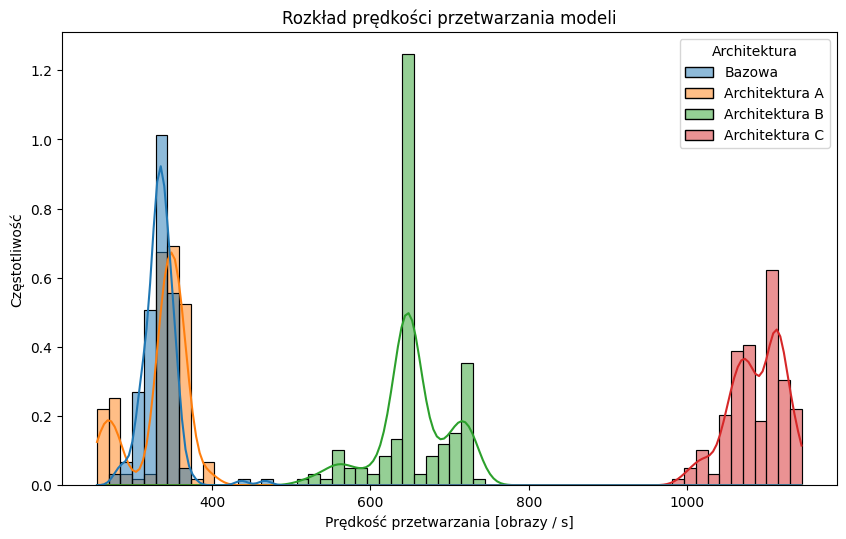

In [95]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.histplot(data=throughput_df, x="throughput [images / s]", hue="Architektura", ax=ax, stat="frequency", kde=True, bins=60)

ax.set_title("Rozkład prędkości przetwarzania modeli")

# small text below title "Ciągłymi liniami przedstawiono gęstość rozkładu"
ax.set_xlabel("Prędkość przetwarzania [obrazy / s]")
ax.set_ylabel("Częstotliwość")